First we load the functions and libraries necessary for this report.

In [1]:
from __future__ import print_function
from lightfm import LightFM

import seaborn as sns
import matplotlib.pyplot as plt

In [59]:
run analysis_functions.ipynb #import all helper functions

For initial analysis, we will explore and model data from only 9000 users. In future sections we will extend this model to more users. 

In [3]:
# Import main dataset
df = pd.read_csv('lastfm_9000_users.csv', na_filter=False)
df = df.drop(['Unnamed: 0'], axis=1)

The structure of the analysis will be as such: 
0. Data Exploration
1. Objective
2. Prepare data
3. Model Fitting, Tuning, and Evaluation
    - Benchmarks
        - Most Popular
        - ALS Matrix Factorization (Implicit)
        - Bayesian Personalized Ranking (Implicit)
    - LightFM
        - FM without Side Info (Vanilla)
        - FM with User/Item Side Information
        - Parameter Tuning
    - Summary of Results between Models (Table)
4. Model Exploration
    - Metrics Used (Recall, Precision, Coverage)
    - Metrics by User Segments 
        - Active/Non-Active
        - Diverse/Non-Diverse 
        - Mainstream/Non-Mainstream 
    - Scale
        - Metrics by Size
        - Training Time / Predict Time by Size
    - Qualitative Results (Serendipity/Novelty)
6. Conclusion / Next Steps

# 0. Data Exploration

Before we dive into modeling, let's take a look at what data currently looks like. 

In [4]:
df.head()

,user_id,artist_mbid,artist_name,plays
0,00029d80b8af94f2d5e3349ceb28b7304f80c1c4,b7ffd2af-418f-4be2-bdd1-22f8b48613da,nine inch nails,11092
1,00029d80b8af94f2d5e3349ceb28b7304f80c1c4,8ca01f46-53ac-4af2-8516-55a909c0905e,my bloody valentine,1671
2,00029d80b8af94f2d5e3349ceb28b7304f80c1c4,e795e03d-b5d5-4a5f-834d-162cfb308a2c,pj harvey,1603
3,00029d80b8af94f2d5e3349ceb28b7304f80c1c4,69ee3720-a7cb-4402-b48d-a02c366f2bcf,the cure,1588
4,00029d80b8af94f2d5e3349ceb28b7304f80c1c4,90cc2464-234e-4da0-b39b-576f36e633bc,antony and the johnsons,1039


Next lets take a first, high-level look at the datset.

In [17]:
df.describe()

,plays
count,438346.000000
mean,216.435998
std,800.547832
min,1.000000
25%,34.000000
50%,94.000000
75%,225.000000
max,242328.000000


In [18]:
df.describe(include = 'O')

,user_id,artist_mbid,artist_name
count,438346,438346,438346
unique,9000,47102,53577
top,1a0cefc82b7f7566d12b69697ea91a29b20f6554,,radiohead
freq,107,5731,1926


It's interesting to see that there are more artist names than artist mbid. This is probably because some artist names share the same mbid (seen below), due to both error and if the same artist have different names. **To distinguish between artists, we will then use artist_mbid.** FERNANDO NEED CODE HERE

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438346 entries, 0 to 438345
Data columns (total 4 columns):
user_id        438346 non-null object
artist_mbid    438346 non-null object
artist_name    438346 non-null object
plays          438346 non-null int64
dtypes: int64(1), object(3)
memory usage: 13.4+ MB


Let's see if there's any missing values within the dataset.

In [6]:
df.isna().sum()

user_id        0
artist_mbid    0
artist_name    0
plays          0
dtype: int64

Let's see if there's any wrong values in the datset.

In [16]:
print('Wrong Values:\n=============')
print('User Id: ', df.loc[df.user_id == ''].shape[0])
print('Artist MBID: ', df.loc[df.artist_mbid == ''].shape[0])
print('Artist Name: ', df.loc[df.artist_name == ''].shape[0])
print('Plays: ', df.loc[df.plays < 0].shape[0])

Wrong Values:
User Id:  0
Artist MBID:  5731
Artist Name:  6
Plays:  0


It looks like there are some invalid values for mbid and name. Let's take a look at them:

In [37]:
len(df.loc[df.artist_mbid == ''])/len(df)

0.013074146906781402

These values are only 1% of the dataset, so for sake of simplicity let us just drop these values. 

In [40]:
df = df[df.artist_mbid != '']
df = df[df.artist_name != '']

In [41]:
#sanity check
print('Wrong Values:\n=============')
print('User Id: ', df.loc[df.user_id == ''].shape[0])
print('Artist MBID: ', df.loc[df.artist_mbid == ''].shape[0])
print('Artist Name: ', df.loc[df.artist_name == ''].shape[0])
print('Plays: ', df.loc[df.plays < 0].shape[0])

Wrong Values:
User Id:  0
Artist MBID:  0
Artist Name:  0
Plays:  0


Next, let's see how the number of plays are distributed within the data.

/home/tim_kartawijaya/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


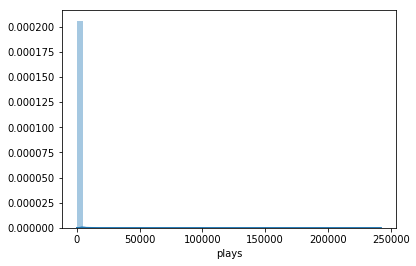

In [42]:
sns.distplot(df.plays)

/home/tim_kartawijaya/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


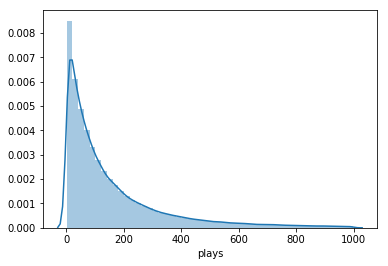

In [43]:
sns.distplot(df[df.plays < 1000].plays)

It's interesting to see how the data is exponentially distributed as shown above. The packages we use should have already accounted for such an imbalance, but in case they don't, let's scale these values.

In [44]:
from sklearn.preprocessing import MinMaxScaler 

df['log_plays'] = df.plays.apply(lambda x: log(x))

df.log_plays *= (1.0/df.log_plays.max())

/home/tim_kartawijaya/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


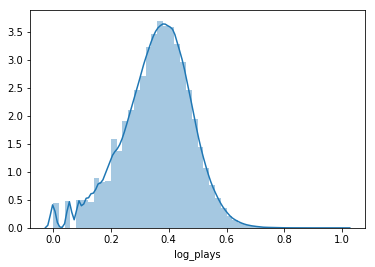

In [45]:
sns.distplot(df.log_plays)

# 1. Objective

The objective for this project is similar as before: to build a reliable recommender system that generates new and relevant artist recommendations to Last.fm users. We will do this by recommending the top-k (e.g. top 20) artists for each user. Each recommendation is personalized to each user and is ‘learnt’ from his or her listening habits and history. The business objective of our recommender system is to increase user activity in Last.fm and user loyalty to the Last.fm brand by providing a service that allows users to discover new artists and have a more enjoyable listening experience. This model is similar to Spotify's "Discover Weekly", but on an artist basis

# 2. Prepare Data

Let's first transform the dataset above to a format that is consumable by the Implicit and LightFM model.

### 2a. Create Sparse Matrix from Dataset

In [48]:
#create sparse matrix
plays_sparse = create_sparse_matrix(df).astype('float')
print('Matrix Sparsity:', calculate_sparsity(plays_sparse))

Creating sparse matrix...


/home/tim_kartawijaya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
/home/tim_kartawijaya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead


Matrix Sparsity: 99.89793628874546


### 2b. Split Data to Train/Test

Split data into train test set, maintaining that each user still has some interactions intact. This custom split train test is only used for the **implicit** package. 

In [49]:
# Split data into training and test sets
train, test, user_count = split_train_test_per_user(plays_sparse, 3, 10)
print("Percentage of original data masked:", pct_masked(plays_sparse, train.T.tocsr()))
print("Users masked:", user_count)


Percentage of original data masked: 0.06637086337585506
Users masked: 8975


Note that the train is in the form of item by user, to accomodate the implicit and baseline models.

In [50]:
train

<47100x8999 sparse matrix of type '<class 'numpy.float64'>'
	with 432600 stored elements in Compressed Sparse Row format>

#### Scaled Train/Test

Next, let's do a similar transformation for the scaled data. 

In [51]:
df_log = df.drop(columns = ['plays'], axis = 1)
# plays_sparse = create_sparse_matrix(df).astype('float')

df_log.columns = ['user_id','artist_mbid','artist_name','plays']

#create sparse matrix
plays_sparse_log = create_sparse_matrix(df_log).astype('float')
print('Matrix Sparsity:', calculate_sparsity(plays_sparse_log))

# Split data into training and test sets
train_log, test_log, user_count_log = split_train_test_per_user(plays_sparse_log, 3, 10)
print("Percentage of original data masked:", pct_masked(plays_sparse_log, train_log.T.tocsr()))
print("Users masked:", user_count_log)

Creating sparse matrix...


/home/tim_kartawijaya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
/home/tim_kartawijaya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead


Matrix Sparsity: 99.89885948639257



Percentage of original data masked: 0.06669071998208442
Users masked: 8934


### 2c. Build Interactions for LightFM

For lightFM, we would need a different kind of format for the datasets. We create them using LightFM's data builders below.

In [52]:
import lightfm
from lightfm.data import Dataset
from lightfm import cross_validation

# Initialize lightfm Dataset()
int_df = df.drop(['artist_name', 'log_plays'], axis=1)
int_data = lightfm.data.Dataset(user_identity_features=True, item_identity_features=True)

# Create tuples for int_df values, as well as separate tuples for user_id and artist_id
tuples = [tuple(x) for x in int_df.values]
user_id = [tuple(x) for x in df.user_id]
artist_id = [tuple(x) for x in df.artist_mbid]

# Fit int_data
int_data.fit(df.user_id, df.artist_mbid)

# Build interactions, weights
interactions, weights = int_data.build_interactions(tuples)

# Create training and test sets for lightFM
train_light, test_light = lightfm.cross_validation.random_train_test_split(plays_sparse, test_percentage=0.6, random_state=None)

In [54]:
test_light

<8999x47100 sparse matrix of type '<class 'numpy.float64'>'
	with 259560 stored elements in COOrdinate format>

In [53]:
train_light

<8999x47100 sparse matrix of type '<class 'numpy.float64'>'
	with 173040 stored elements in COOrdinate format>

# 3. Model Fitting, Tuning, and Evaluation

Next, we set up our models to perform recommendations on the Lastfm datasets. Compared to our previous attempt, we will now use a more sophisticated take on building a recommendation engine: Factorization Machines (FM). Our motivation in using FMs is to utilize the side information we have on users (age, gender, etc.) to improve our metrics. We decided to use LightFM's implementation of FMs due to its known efficiency and good results. Our benchmarks to beat will be the "most popular" model and the ALS Implicit Matrix Factorization.

For Baseline and Implicit models, we will be focusing on the following metrics:
1. Recall at k 
2. Precision at k 
3. NDCG at k 
4. Coverage

We define recall@k as: the number of positive items in the first k positions of the ranked list of results divided by the number of positive items in the test period.

We define precision@k as: the fraction of known positives in the first k positions of the ranked list of results.

For the LightFM models, we will be using:
1. Recall at k 
2. Precision at k
3. Coverage

NDCG isn't covered in LightFM models since it is not supported within the LightFM package. Furthermore, our attempt at calculating NDCG on our own did not turn out as expected, as the results did not make sense (much lower than recall @ k). 

## 3a. Benchmarks

### Baseline: Most Popular

The "baseline" recommends the most-popular artists to everyone, regardless of their play history. Implementation of the baseline model can be found in analysis_functions.ipynb. (To do: refactor models to separate Python scripts).

In [55]:
model_baseline = Baseline(n_recs = 20)
model_baseline.fit(train)

Fitting baseline...
[3.24727e+05 3.37390e+04 6.50140e+04 ... 2.80000e+01 2.70000e+01
 2.40000e+01]


No tuning is necessary since there are no parameters. We then evaluate the test set below: 

In [20]:
coverage, precision, recall, ndcg = evaluate(model_baseline, "baseline", test, plays_sparse)
print("Precision:",precision*100,'%')
print("Recall:",recall*100,'%')
print("Coverage:",coverage*100,'%')
print("Average NDCG per User:",ndcg*100,'%')

Evaluating model...



Precision: 1.175946547884187 %
Recall: 7.839643652561247 %
Coverage: 0.04246104199397053 %
Average NDCG per User: 4.700608311766834 %


### Model-Based (ALS)

Here we fit the model-based ALS Matrix Factorization using the implicit package from our past assignment and use the parameters that were found to be optimized in the HW 2 report. 

In [21]:
model_als = implicit.als.AlternatingLeastSquares(factors = 30, regularization = 0.01)

# Train model
print("Fitting model...")
model_als.fit(train)

  0%|          | 0/15 [00:00<?, ?it/s]

Fitting model...


100%|██████████| 15.0/15 [00:20<00:00,  1.54s/it]


In [22]:
coverage, precision, recall, ndcg = evaluate(model_als, "implicit", test, train.T.tocsr())
print("Precision:",precision*100,'%')
print("Recall:",recall*100,'%')
print("Coverage:",coverage*100,'%')
print("Average NDCG per User:",ndcg*100,'%')

Evaluating model...



Precision: 3.2605790645879735 %
Recall: 21.73719376391982 %
Coverage: 8.481593138295613 %
Average NDCG per User: 0.0 %


### Bayesian Personalized Ranking (Implicit)

Since in lightFM we will mainly be focused on using the bpr loss function, we will also implement Implicit's BPR model as a point of comparison. 

In [56]:
model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors = 30, regularization = 0.01)

# Train model
print("Fitting model...")
model_bpr.fit(train)

coverage, precision, recall, ndcg = evaluate(model_bpr, "implicit", test, plays_sparse)
print("Precision:",precision*100,'%')
print("Recall:",recall*100,'%')
print("Coverage:",coverage*100,'%')
print("Average NDCG per User:",ndcg*100,'%')

  3%|▎         | 3/100 [00:00<00:04, 20.94it/s, correct=50.33%, skipped=2.18%]

Fitting model...


100%|██████████| 100/100 [00:04<00:00, 20.39it/s, correct=94.07%, skipped=2.19%]

Evaluating model...



Precision: 3.37158774373259 %
Recall: 22.477251624883937 %
Coverage: 12.297239915074309 %
Average NDCG per User: 12.930256130213369 %


### LightFM (without side information)

First, we fit the LightFM model without using side information, in the hopes of replicating the results of the MF models above. 

In [60]:
model_fm_vanilla = LightFM(learning_rate=0.05, loss='warp')

#train model
print("Fitting model...")
model_fm_vanilla.fit(train_light, epochs=10)

#evaluate model
coverage, precision, recall = evaluate_lightfm(model_fm_vanilla, interactions, train_light, test_light)
print("Precision:",precision*100,'%')
print("Recall:",recall*100,'%')
print("Coverage:",coverage*100,'%')

Fitting model...
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
Precision: 10.704679042100906 %
Recall: 7.412755207661769 %
Coverage: 2.575371549893843 %


Now we try to find the best hyperparameter for this model and use the model with the best hyperparameter to get our results.

We first try to tune the dimensionality of the feature embeddings to try to find the best recall, which we consider it important to have at least a few items that the user consider relevant within the top k results. Recall also relates directly to precision and NDCG. At the same time, we would need to consider coverage, as we want to expand the user's tastes as much as we could. 

In [ ]:
test_model = LightFM
params = [10,20,30,40,50]
k_fold = 4
n_recs = 20
ndcg_list, heatmap_list = auto_tune_parameter(k = k_fold, interactions = 20, test_model, plays_sparse, params)

Fitting fold number... 0
Trying  10
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
0
Trying  20
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
1
Trying  30
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
2
Trying  40
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
3
Trying  50
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
4
Fold  0  beat the record for recall!
New best recall is  0.11211102989546595
New best param is  50
end of fold---------------------------
Fitting fold number... 1
Trying  10
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
0
Trying  20
Evaluating LightFM...
Calculating Coverage...



Calculating Recall at k...
Calculating Precision at k...
1
Trying  30
Evaluating LightFM...
Calculating Coverage...


/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


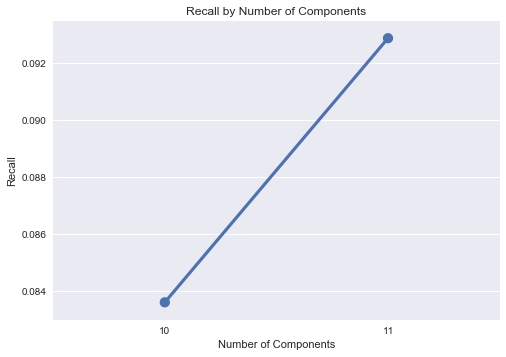

In [79]:
#Plot Recall by Number of Components
recall_values = heatmap_list[0]

recall_heatmap_components = pd.DataFrame({'N':tries, 'Recall': recall_values})
sns.pointplot(x='N',y='Recall',data=recall_heatmap_components)
plt.title('Recall by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Recall')

plt.show()

### LightFM (with side information)

Next, we will try to fit LightFM with side information and check if it improves our model.

In [46]:
user_feat = pd.read_csv("user_features_9000.csv")
user_feat = user_feat[user_feat.columns[1:]]
user_features = scipy.sparse.csr_matrix(user_feat.values)

In [48]:
model_fm = LightFM(learning_rate=0.05, loss='warp')

# Train Model
print("Fitting model...")
model_fm.fit(train_light, user_features=user_features, epochs=10)

Fitting model...


In [29]:
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import recall_at_k

train_precision = precision_at_k(model_fm, train_light, user_features=user_features, k=10).mean()
test_precision = precision_at_k(model_fm, test_light, user_features=user_features, k=10).mean()

train_recall = recall_at_k(model_fm, train_light, user_features=user_features).mean()
test_recall = recall_at_k(model_fm, test_light, user_features=user_features).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('Recall: train %.2f, test %.2f.' % (train_recall, test_recall))

Precision: train 0.08, test 0.11.
Recall: train 0.04, test 0.04.


In [52]:
#coverage, precision, recall, ndcg = evaluate(model_fm_vanilla, "lightfm", test, plays_sparse,liked=train.T.tocsr())
coverage, precision, recall = evaluate_lightfm(model_fm, interactions, train_light, test_light, user_features=user_features)
print("Precision:",precision*100,'%')
print("Recall:",recall*100,'%')
print("Coverage:",coverage*100,'%')


Precision: 8.909879624843597 %
Recall: 6.2011703730880985 %
Coverage: 0.04246104199397053 %


Now we try to find the best hyperparameter for this model with the best hyperparameter to get our results.

Tuning one parameter: number components. We try values [5,10,15,20]

In [82]:
testmodel=LightFM
tries=[9,10,11,12]
start = time.time()
ndcg_list,heatmap_list=auto_tune_parameter(4,20,testmodel,plays_sparse,tries,user_features=user_features,item_features=None)
stop = time.time()
total = stop-start

Fitting fold number... 0
Trying  10


0
Fold  0  beat the record for recall!
New best recall is  0.06197524462540848
New best param is  10
end of fold---------------------------


The recall on the test set is  0.0629244852092972 , after hyperparameter optimization
The precision on the test set is  0.030190151 , after hyperparameter optimization
The coverage on the test set is  0.01730287461254299 , after hyperparameter optimization


In [ ]:
#Plot Recall by Number of Components
recall_values=heatmap_list[0]
# Plot NDCG by Activity Level
recall_heatmap_components = pd.DataFrame({'N':tries, 'Recall': recall_values})
sns.pointplot(x='N',y='Recall',data=recall_heatmap_components)
plt.title('Recall by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Recall')

plt.show()

### Summary of Performance Results (Table)

# 4. Model Exploration

Next, we explore these models even more. How do they perform in regards to size, different user population?

## 4a. Performance by User Type

In [33]:
run grouping_functions.ipynb

### Active/Non-Active

In [21]:
import seaborn as sns

In [78]:
n=3
activity_groups=active_users(plays_sparse, n)
levels=[1,2,3]
ndcg_activity_als = []
recall_activity_als = []
precision_activity_als = []
coverage_activity_als = []

ndcg_activity_baseline = []
recall_activity_baseline = []
precision_activity_baseline = []
coverage_activity_baseline = []

for group in activity_groups:
    #print('Matrix Sparsity:', calculate_sparsity(group))
    # Compute the recall and ndcg using optimal parameters for the ALS model on different dataset sizes
    train, test, user_count = split_train_test_per_user(group, 4, 20)
    # train model 
    print("Fitting model...")
    #FIRST, BASELINE------------------------------
    model=Baseline(20)
    model.fit(train)
    coverage, precision, recall, ndcg = evaluate(model,"baseline", test, group)

    recall_activity_baseline.append(recall)
    ndcg_activity_baseline.append(ndcg)
    precision_activity_baseline.append(precision)
    coverage_activity_baseline.append(coverage)
    
    #SECOND, ALS-------------------------------------
    model = implicit.als.AlternatingLeastSquares(factors=30, regularization=0.01)
    model.fit(train, show_progress=True)
    
    coverage, precision, recall, ndcg = evaluate(model,"implicit", test, group)

    recall_activity_als.append(recall)
    ndcg_activity_als.append(ndcg)
    precision_activity_als.append(precision)
    coverage_activity_als.append(coverage)


Fitting model...
Fitting baseline...
[6194. 1352. 3513. ...   28.   27.   24.]
Evaluating model...


  7%|▋         | 1.0/15 [00:00<00:01,  9.12it/s]


Recall: 6.775956284153005 %
Average NDCG: 4.786805185772901 %
Coverage: 0.04246104199397053 %
Precision: 1.6939890710382512 %


100%|██████████| 15.0/15 [00:01<00:00,  8.08it/s]

Evaluating model...



Recall: 16.612021857923498 %
Average NDCG: 10.995741640367491 %
Coverage: 5.161139654367118 %
Precision: 4.1530054644808745 %



Fitting model...
Fitting baseline...
[37800.  6650. 11395. ...     0.     0.     0.]
Evaluating model...


  0%|          | 0/15 [00:00<?, ?it/s]


Recall: 6.980313646980314 %
Average NDCG: 4.854039254270085 %
Coverage: 0.04246104199397053 %
Precision: 1.7450784117450786 %


100%|██████████| 15.0/15 [00:02<00:00,  6.48it/s]

Evaluating model...



Recall: 17.31731731731732 %
Average NDCG: 12.098077565521345 %
Coverage: 6.250265381512462 %
Precision: 4.32932932932933 %



Fitting model...
Fitting baseline...
[230791.  23444.  45401. ...      0.      0.      0.]
Evaluating model...


  0%|          | 0/15 [00:00<?, ?it/s]


Recall: 7.636849132176235 %
Average NDCG: 5.261193931189853 %
Coverage: 0.04246104199397053 %
Precision: 1.9092122830440588 %


100%|██████████| 15.0/15 [00:02<00:00,  5.72it/s]

Evaluating model...



Recall: 16.79572763684913 %
Average NDCG: 10.91549543986731 %
Coverage: 6.946626470213579 %
Precision: 4.198931909212282 %


/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


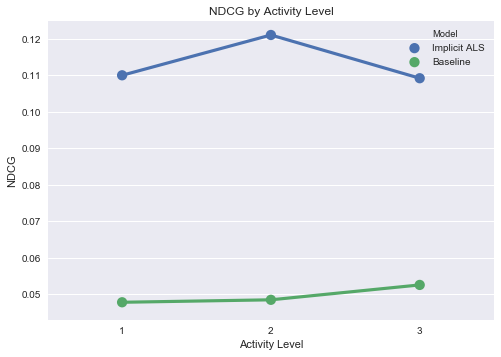

In [79]:
# Plot NDCG by Activity Level
ndcg_activity_als_df = pd.DataFrame({'N':levels, 'NDCG': ndcg_activity_als})
ndcg_activity_baseline_df = pd.DataFrame({'N':levels, 'NDCG': ndcg_activity_baseline})
f, ax = plt.subplots(1, 1)

ndcg_activity_als_df['Model'] = 'Implicit ALS'
ndcg_activity_baseline_df['Model'] = 'Baseline'
df = pd.concat([ndcg_activity_als_df,ndcg_activity_baseline_df])
sns.pointplot(ax=ax,x='N',y='NDCG',data=df,hue='Model')
plt.title('NDCG by Activity Level')
plt.xlabel('Activity Level')
plt.ylabel('NDCG')

plt.show()

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


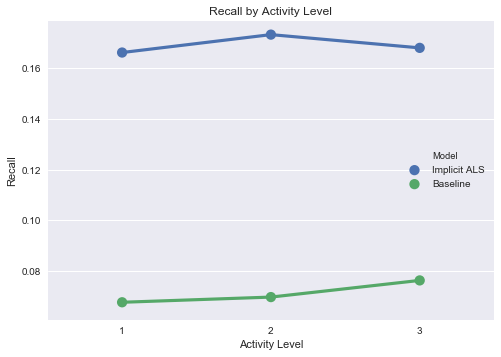

In [80]:
# Plot Recall by Activity Level
recall_activity_als_df = pd.DataFrame({'N':levels, 'Recall': recall_activity_als})
recall_activity_baseline_df = pd.DataFrame({'N':levels, 'Recall': recall_activity_baseline})
f, ax = plt.subplots(1, 1)

recall_activity_als_df['Model'] = 'Implicit ALS'
recall_activity_baseline_df['Model'] = 'Baseline'
df = pd.concat([recall_activity_als_df,recall_activity_baseline_df])
sns.pointplot(ax=ax,x='N',y='Recall',data=df,hue='Model')
plt.title('Recall by Activity Level')
plt.xlabel('Activity Level')
plt.ylabel('Recall')

plt.show()

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


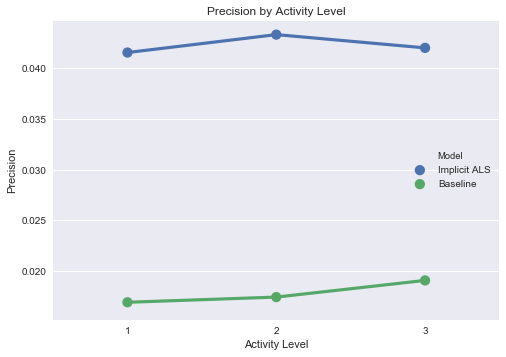

In [83]:
# Plot Precision by Activity Level
precision_activity_als_df = pd.DataFrame({'N':levels, 'Precision': precision_activity_als})
precision_activity_baseline_df = pd.DataFrame({'N':levels, 'Precision': precision_activity_baseline})
f, ax = plt.subplots(1, 1)

precision_activity_als_df['Model'] = 'Implicit ALS'
precision_activity_baseline_df['Model'] = 'Baseline'
df = pd.concat([precision_activity_als_df,precision_activity_baseline_df])
sns.pointplot(ax=ax,x='N',y='Precision',data=df,hue='Model')
plt.title('Precision by Activity Level')
plt.xlabel('Activity Level')
plt.ylabel('Precision')

plt.show()

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


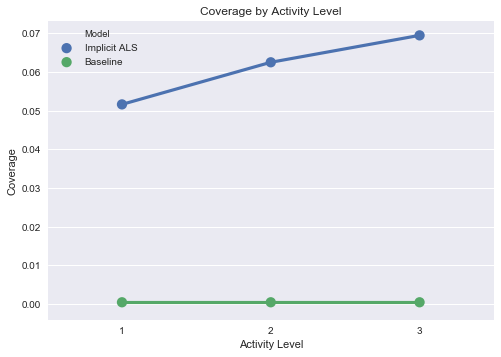

In [84]:
# Plot Coverage by Diversity Level
coverage_activity_als_df = pd.DataFrame({'N':levels, 'Coverage': coverage_activity_als})
coverage_activity_baseline_df = pd.DataFrame({'N':levels, 'Coverage': coverage_activity_baseline})
f, ax = plt.subplots(1, 1)

coverage_activity_als_df['Model'] = 'Implicit ALS'
coverage_activity_baseline_df['Model'] = 'Baseline'
df = pd.concat([coverage_activity_als_df,coverage_activity_baseline_df])
sns.pointplot(ax=ax,x='N',y='Coverage',data=df,hue='Model')
plt.title('Coverage by Activity Level')
plt.xlabel('Activity Level')
plt.ylabel('Coverage')

plt.show()

### Diverse/Non-Diverse

In [72]:
n=3
diversity_groups=diverse_users(plays_sparse, n)
levels=[1,2,3]
ndcg_div_als = []
recall_div_als = []
precision_div_als = []
coverage_div_als = []

ndcg_div_baseline = []
recall_div_baseline = []
precision_div_baseline = []
coverage_div_baseline = []

for group in diversity_groups:
    #print('Matrix Sparsity:', calculate_sparsity(group))
    # Compute the recall and ndcg using optimal parameters for the ALS model on different dataset sizes
    train, test, user_count = split_train_test_per_user(group, 4, 20)
    # train model 
    print("Fitting model...")
    #FIRST, BASELINE------------------------------
    model=Baseline(20)
    model.fit(train)
    coverage, precision, recall, ndcg = evaluate(model,"baseline", test, group)

    recall_div_baseline.append(recall)
    ndcg_div_baseline.append(ndcg)
    precision_div_baseline.append(precision)
    coverage_div_baseline.append(coverage)
    
    #SECOND, ALS-------------------------------------
    model = implicit.als.AlternatingLeastSquares(factors=30, regularization=0.01)
    model.fit(train, show_progress=True)
    
    coverage, precision, recall, ndcg = evaluate(model,"implicit", test, group)

    recall_div_als.append(recall)
    ndcg_div_als.append(ndcg)
    precision_div_als.append(precision)
    coverage_div_als.append(coverage)


Fitting model...
Fitting baseline...
[1.04349e+05 9.22100e+03 1.56230e+04 ... 2.80000e+01 2.70000e+01
 2.40000e+01]
Evaluating model...


  0%|          | 0/15 [00:00<?, ?it/s]


Recall: 7.006500171057133 %
Average NDCG: 4.426799197570511 %
Coverage: 0.04246104199397053 %
Precision: 1.7516250427642832 %


100%|██████████| 15.0/15 [00:02<00:00,  5.45it/s]

Evaluating model...



Recall: 16.161477933629833 %
Average NDCG: 10.992684674944448 %
Coverage: 5.9318075665576835 %
Precision: 4.040369483407458 %



Fitting model...
Fitting baseline...
[92344.  8570. 26077. ...     0.     0.     0.]
Evaluating model...


  7%|▋         | 1.0/15 [00:00<00:01,  7.14it/s]


Recall: 7.5050033355570385 %
Average NDCG: 5.2637730179707 %
Coverage: 0.04246104199397053 %
Precision: 1.8762508338892596 %


100%|██████████| 15.0/15 [00:01<00:00,  8.24it/s]

Evaluating model...



Recall: 16.110740493662444 %
Average NDCG: 10.65406927764402 %
Coverage: 5.8023013884760735 %
Precision: 4.027685123415611 %



Fitting model...
Fitting baseline...
[75484. 16468. 24400. ...     0.     0.     0.]
Evaluating model...


  7%|▋         | 1.0/15 [00:00<00:02,  6.80it/s]


Recall: 6.3133333333333335 %
Average NDCG: 4.518626024119206 %
Coverage: 0.04246104199397053 %
Precision: 1.5783333333333334 %


100%|██████████| 15.0/15 [00:02<00:00,  7.92it/s]

Evaluating model...



Recall: 16.813333333333333 %
Average NDCG: 11.054940021194678 %
Coverage: 6.394632924291963 %
Precision: 4.203333333333333 %


/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


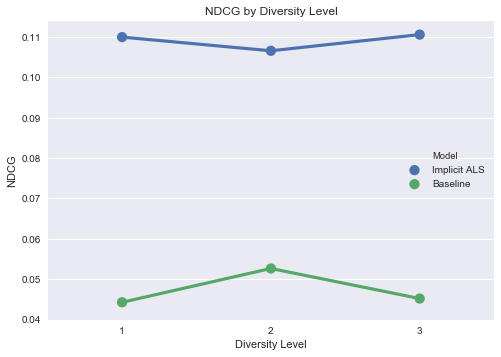

In [74]:
# Plot NDCG by Diversity Level
ndcg_div_als_df = pd.DataFrame({'N':levels, 'NDCG': ndcg_div_als})
ndcg_div_baseline_df = pd.DataFrame({'N':levels, 'NDCG': ndcg_div_baseline})
f, ax = plt.subplots(1, 1)

ndcg_div_als_df['Model'] = 'Implicit ALS'
ndcg_div_baseline_df['Model'] = 'Baseline'
df = pd.concat([ndcg_div_als_df,ndcg_div_baseline_df])
sns.pointplot(ax=ax,x='N',y='NDCG',data=df,hue='Model')
plt.title('NDCG by Diversity Level')
plt.xlabel('Diversity Level')
plt.ylabel('NDCG')

plt.show()

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


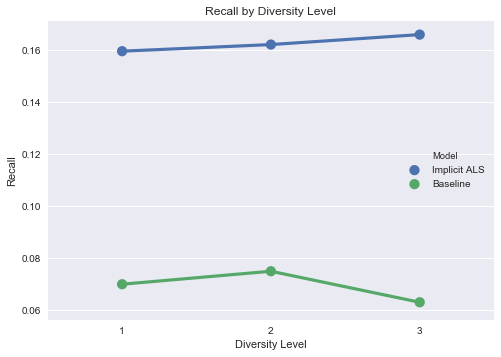

In [60]:
# Plot Recall by Diversity Level
recall_div_als_df = pd.DataFrame({'N':levels, 'Recall': recall_div_als})
recall_div_baseline_df = pd.DataFrame({'N':levels, 'Recall': recall_div_baseline})
f, ax = plt.subplots(1, 1)

recall_div_als_df['Model'] = 'Implicit ALS'
recall_div_baseline_df['Model'] = 'Baseline'
df = pd.concat([recall_div_als_df,recall_div_baseline_df])
sns.pointplot(ax=ax,x='N',y='Recall',data=df,hue='Model')
plt.title('Recall by Diversity Level')
plt.xlabel('Diversity Level')
plt.ylabel('Recall')

plt.show()

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


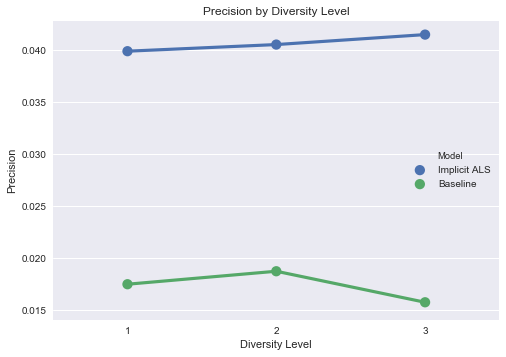

In [62]:
# Plot Precision by Diversity Level
precision_div_als_df = pd.DataFrame({'N':levels, 'Precision': precision_div_als})
precision_div_baseline_df = pd.DataFrame({'N':levels, 'Precision': precision_div_baseline})
f, ax = plt.subplots(1, 1)

precision_div_als_df['Model'] = 'Implicit ALS'
precision_div_baseline_df['Model'] = 'Baseline'
df = pd.concat([precision_div_als_df,precision_div_baseline_df])
sns.pointplot(ax=ax,x='N',y='Precision',data=df,hue='Model')
plt.title('Precision by Diversity Level')
plt.xlabel('Diversity Level')
plt.ylabel('Precision')

plt.show()

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


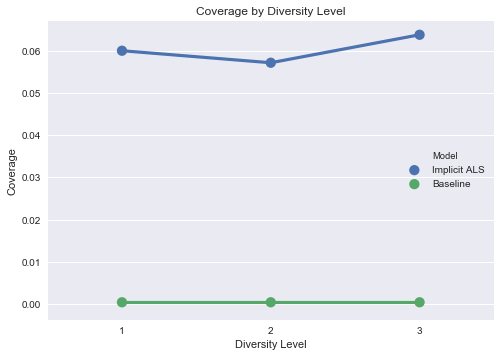

In [63]:
# Plot Coverage by Diversity Level
coverage_div_als_df = pd.DataFrame({'N':levels, 'Coverage': coverage_div_als})
coverage_div_baseline_df = pd.DataFrame({'N':levels, 'Coverage': coverage_div_baseline})
f, ax = plt.subplots(1, 1)

coverage_div_als_df['Model'] = 'Implicit ALS'
coverage_div_baseline_df['Model'] = 'Baseline'
df = pd.concat([coverage_div_als_df,coverage_div_baseline_df])
sns.pointplot(ax=ax,x='N',y='Coverage',data=df,hue='Model')
plt.title('Coverage by Diversity Level')
plt.xlabel('Diversity Level')
plt.ylabel('Coverage')

plt.show()

### Mainstream / Non-Mainstream

In [87]:
n=3
ms_groups=mainstream_users(plays_sparse, top_artists=20, n=3)
levels=[1,2,3]
ndcg_ms_als = []
recall_ms_als = []
precision_ms_als = []
coverage_ms_als = []

ndcg_ms_baseline = []
recall_ms_baseline = []
precision_ms_baseline = []
coverage_ms_baseline = []

for group in ms_groups:
    #print('Matrix Sparsity:', calculate_sparsity(group))
    # Compute the recall and ndcg using optimal parameters for the ALS model on different dataset sizes
    train, test, user_count = split_train_test_per_user(group, 4, 20)
    # train model 
    print("Fitting model...")
    #FIRST, BASELINE------------------------------
    model=Baseline(20)
    model.fit(train)
    coverage, precision, recall, ndcg = evaluate(model,"baseline", test, group)

    print("Recall:",recall*100,'%')
    print("Average NDCG:",ndcg*100,'%')
    print("Coverage:",coverage*100,'%')
    print("Precision:",precision*100,'%')

    recall_ms_baseline.append(recall)
    ndcg_ms_baseline.append(ndcg)
    precision_ms_baseline.append(precision)
    coverage_ms_baseline.append(coverage)
    
    #SECOND, ALS-------------------------------------
    model = implicit.als.AlternatingLeastSquares(factors=30, regularization=0.01)
    model.fit(train, show_progress=True)
    
    coverage, precision, recall, ndcg = evaluate(model,"implicit", test, group)
    print("Recall:",recall*100,'%')
    print("Average NDCG:",ndcg*100,'%')
    print("Coverage:",coverage*100,'%')
    print("Precision:",precision*100,'%')

    recall_ms_als.append(recall)
    ndcg_ms_als.append(ndcg)
    precision_ms_als.append(precision)
    coverage_ms_als.append(coverage)


Fitting model...
Fitting baseline...
[ 7392.  9617. 19081. ...     0.     0.     0.]
Evaluating model...


  0%|          | 0/15 [00:00<?, ?it/s]

Recall: 2.46704967894559 %
Average NDCG: 1.1848020638967913 %
Coverage: 0.04246104199397053 %
Precision: 0.6167624197363974 %


100%|██████████| 15.0/15 [00:02<00:00,  7.68it/s]

Evaluating model...



Recall: 15.417370733355865 %
Average NDCG: 10.138706403826662 %
Coverage: 7.600526516920725 %
Precision: 3.8543426833389662 %



Fitting model...
Fitting baseline...
[3.7673e+04 1.2332e+04 1.7039e+04 ... 2.8000e+01 2.7000e+01 2.4000e+01]
Evaluating model...


  7%|▋         | 1.0/15 [00:00<00:01,  7.23it/s]


Recall: 5.693135935397039 %
Average NDCG: 3.3300714657079413 %
Coverage: 0.04246104199397053 %
Precision: 1.4232839838492597 %


100%|██████████| 15.0/15 [00:01<00:00,  8.43it/s]

Evaluating model...



Recall: 15.0 %
Average NDCG: 10.01600382016395 %
Coverage: 5.961530295953462 %
Precision: 3.75 %



Fitting model...
Fitting baseline...
[271820.  12408.  31613. ...      0.      0.      0.]
Evaluating model...


  7%|▋         | 1.0/15 [00:00<00:01,  7.54it/s]


Recall: 12.40133779264214 %
Average NDCG: 9.70676309374585 %
Coverage: 0.04246104199397053 %
Precision: 3.100334448160535 %


100%|██████████| 15.0/15 [00:02<00:00,  7.86it/s]

Evaluating model...



Recall: 17.270903010033443 %
Average NDCG: 10.589528010532689 %
Coverage: 4.110228865016348 %
Precision: 4.317725752508361 %


/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


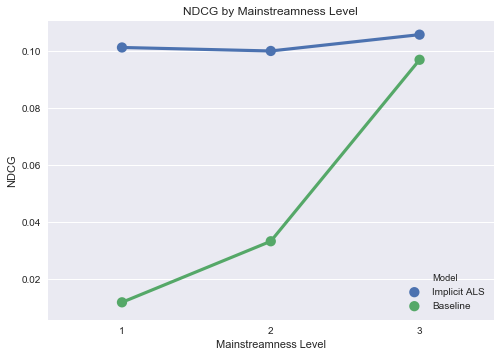

In [88]:
# Plot NDCG by Mainstreamness Level
ndcg_ms_als_df = pd.DataFrame({'N':levels, 'NDCG': ndcg_ms_als})
ndcg_ms_baseline_df = pd.DataFrame({'N':levels, 'NDCG': ndcg_ms_baseline})
f, ax = plt.subplots(1, 1)

ndcg_ms_als_df['Model'] = 'Implicit ALS'
ndcg_ms_baseline_df['Model'] = 'Baseline'
df = pd.concat([ndcg_ms_als_df,ndcg_ms_baseline_df])
sns.pointplot(ax=ax,x='N',y='NDCG',data=df,hue='Model')
plt.title('NDCG by Mainstreamness Level')
plt.xlabel('Mainstreamness Level')
plt.ylabel('NDCG')

plt.show()

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


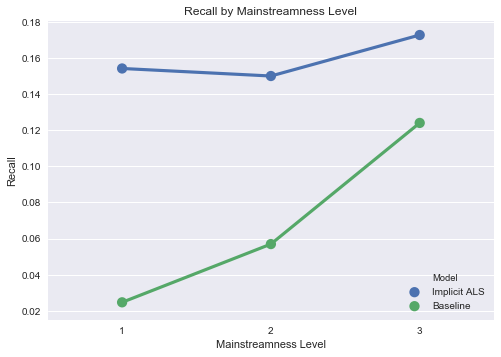

In [89]:
# Plot Recall by Mainstreamness Level
recall_ms_als_df = pd.DataFrame({'N':levels, 'Recall': recall_ms_als})
recall_ms_baseline_df = pd.DataFrame({'N':levels, 'Recall': recall_ms_baseline})
f, ax = plt.subplots(1, 1)

recall_ms_als_df['Model'] = 'Implicit ALS'
recall_ms_baseline_df['Model'] = 'Baseline'
df = pd.concat([recall_ms_als_df,recall_ms_baseline_df])
sns.pointplot(ax=ax,x='N',y='Recall',data=df,hue='Model')
plt.title('Recall by Mainstreamness Level')
plt.xlabel('Mainstreamness Level')
plt.ylabel('Recall')

plt.show()

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


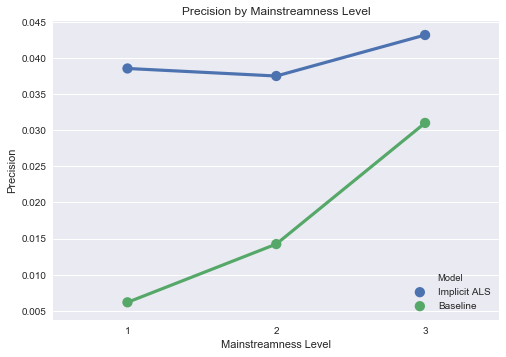

In [90]:
# Plot Precision by Mainstreamness Level
precision_ms_als_df = pd.DataFrame({'N':levels, 'Precision': precision_ms_als})
precision_ms_baseline_df = pd.DataFrame({'N':levels, 'Precision': precision_ms_baseline})
f, ax = plt.subplots(1, 1)

precision_ms_als_df['Model'] = 'Implicit ALS'
precision_ms_baseline_df['Model'] = 'Baseline'
df = pd.concat([precision_ms_als_df,precision_ms_baseline_df])
sns.pointplot(ax=ax,x='N',y='Precision',data=df,hue='Model')
plt.title('Precision by Mainstreamness Level')
plt.xlabel('Mainstreamness Level')
plt.ylabel('Precision')

plt.show()

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


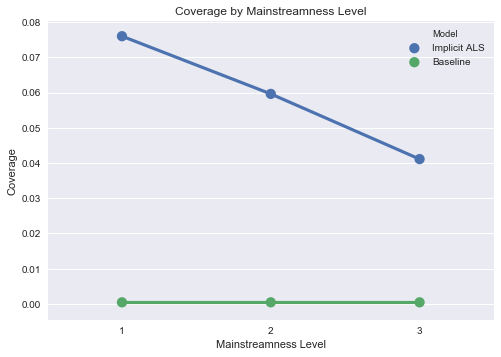

In [91]:
# Plot Coverage by Mainstreamness Level
coverage_ms_als_df = pd.DataFrame({'N':levels, 'Coverage': coverage_ms_als})
coverage_ms_baseline_df = pd.DataFrame({'N':levels, 'Coverage': coverage_ms_baseline})
f, ax = plt.subplots(1, 1)

coverage_ms_als_df['Model'] = 'Implicit ALS'
coverage_ms_baseline_df['Model'] = 'Baseline'
df = pd.concat([coverage_ms_als_df,coverage_ms_baseline_df])
sns.pointplot(ax=ax,x='N',y='Coverage',data=df,hue='Model')
plt.title('Coverage by Mainstreamness Level')
plt.xlabel('Mainstreamness Level')
plt.ylabel('Coverage')

plt.show()

## 4b. Performance by Input Size 

Next, we will see how our model scales, in regards to accuracy and running time. 

In [ ]:
#import full dataset: you can find data in 
#https://www.dropbox.com/s/nbdeiujmsi9l7ny/lastfm_150k_users.csv.zip?dl=0
df_all = pd.read_csv("lastfm_150k_users.csv")

In [ ]:
#Helper function to sample full dataset
def get_users(df, n):
    sample_userid = df["user_id"].unique()
    sample_userid = np.random.choice(sample_userid, size = n, replace = False)

    #grab rows with sample user id
    df_sample = df[df.user_id.isin(sample_userid)].reset_index(drop = True)

    return df_sample

In [ ]:
sizes = [9000]

precision_all = []
recall_all = []
coverage_all = []
train_time = []
recommend_time = []

for size in sizes: 
    print("Modeling ", size, " users...")
    
    df_sample = get_users(df_all, size)
    df_sample = df_sample.drop(['Unnamed: 0'], axis=1)
    
    #create FM model with tuned parameters
    model_fm = LightFM(learning_rate=0.05, loss='warp')
    
    #create sparse matrix
    plays_sparse = create_sparse_matrix(df_sample)
    print('Matrix Sparsity:', calculate_sparsity(plays_sparse))
    
    #split train test
    train, test = random_train_test_split(plays_sparse)
    
    start = timeit.timeit()
    
    #train model
    print("Fitting model...")
    model_fm.fit(train, epochs = 30)
    
    end = timeit.timeit()
    train_t = end-start
    
    #evaluate model 
    print("Evaluating model...")
    coverage, precision, recall = evaluate_lightfm(model_fm, plays_sparse, train, test)
    print("Precision:",precision*100,'%')
    print("Recall:",recall*100,'%')
    print("Coverage:",coverage*100,'%')
    
    #time recommend time
    start = timeit.timeit()
    
    print("Recommending item...")
    (-model.predict(0,np.arange(original.shape[1]))).argsort()[:20]
    
    end = timeit.timeit()
    
    recommend_t = end-start
    
    precision_all.append(precision)
    recall_all.append(recall)
    coverage_all.append(coverage)
    train_time.append(train_t)
    recommend_time.append(recommend_t)
    
    print("Finish! \n ========================")

In [ ]:
# Plot Training Time by Input Size
als_train_time_df = pd.DataFrame({'N':size, 'NDCG': als_train_time})
base_train_time_df = pd.DataFrame({'N':size, 'NDCG': base_train_time})
fm_train_time_df = pd.DataFrame({'N':size, 'NDCG': fm_train_time})

f, ax = plt.subplots(1, 1)
als_train_time_df['Model'] = 'Implicit ALS'
base_train_time_df['Model'] = 'Baseline'
fm_train_time_df['Model'] = 'Factorization Machine'
df = pd.concat([als_train_time_df,base_train_time_df,fm_train_time_df])
sns.pointplot(ax=ax,x='N',y='NDCG',data=df,hue='Model')
plt.title('Training Time by Input Size for Factorization Machine')
plt.xlabel('Number of Users')
plt.ylabel('Time (s)')

plt.show()

## 

# 5. Conclusion / Next Steps